<a href="https://colab.research.google.com/github/mouraffa/Skimlit-NLP-Model-for-Sentence-Classification-in-Paper-Abstracts/blob/main/Skimlit_NLP_Model_for_Sentence_Classification_in_Paper_Abstracts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skimlit: NLP Model for Sentence Classification in Paper Abstracts

Welcome to the Skimlit project notebook! In this notebook, we will explore the development of a Natural Language Processing (NLP) model for classifying sentences in paper abstracts into distinct roles such as objective, methods, results, etc. The primary goal is to assist researchers in efficiently skimming through literature and delving deeper when necessary.

## Project Overview:

In this project, we aim to replicate the results of the paper "Neural Networks for Joint Sentence Classification in Medical Paper Abstracts" using the PubMed 20k RCT dataset. We'll leverage TensorFlow and various NLP techniques to train a model that accurately classifies sentences in paper abstracts.

## Table of Contents:

1. [Confirm Access to GPU](#confirm-access-to-gpu)
2. [Getting the Data](#getting-the-data)
3. [Preparing Data](#preparing-data)
   - Get list of sentences
   - Make numeric labels
   - Label encode labels
   - Let's check what we have until now!
4. [Baseline Model](#baseline-model)
   - Create a helper function to calculate metrics
5. [Preparing the Data for Deep Sequence Models](#preparing-the-data-for-deep-sequence-models)
   - Create the text vectorizer
   - Pretrained token embeddings
   - Character embeddings
   - Creating a character-level tokenizer
   - Creating a character-level embedding
6. [Line Number Input & Total Line Input](#line-number-input--total-line-input)
   - Create the architecture
   - Create tribrid embedding dataset and fit the model
7. [Compare Model Results](#compare-model-results)

Feel free to navigate through the sections using the provided links to explore each step of the project. Let's dive in and build an efficient sentence classification model for paper abstracts!


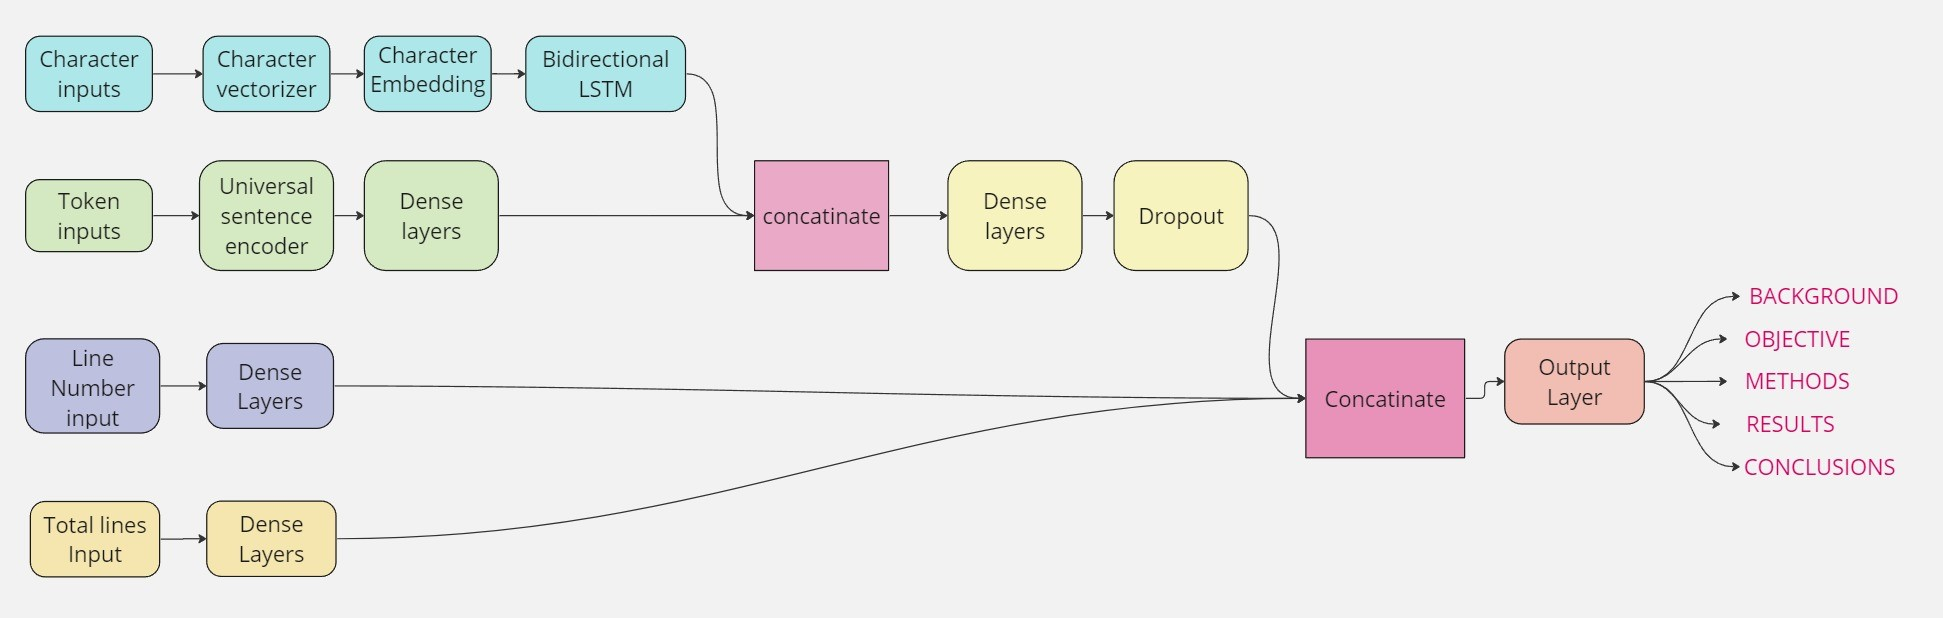

In [ ]:
# Import the datetime module to work with date and time
import datetime

# Print the current date and time to indicate when the notebook was last run
current_time = datetime.datetime.now()
print(f"Notebook last run (end-to-end): {current_time}")


Notebook last run (end-to-end): 2023-12-20 17:39:20.524981


# Confirm Access to GPU

In [ ]:
# Check for the presence of a GPU using the nvidia-smi command
# This is useful to ensure that the notebook is utilizing GPU resources if available

# Using the shell command to check for GPU information
!nvidia-smi

Thu Dec 21 09:49:40 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Getting the Data

Before we commence building a model, it is essential to download the PubMed 200k RCT dataset.

The authors of the paper have generously made the data they utilized for their research publicly available for free. You can access the dataset in the form of .txt files [on GitHub](https://github.com/Franck-Dernoncourt/pubmed-rct).

To acquire the data locally, you can use the following command:

```bash
git clone https://github.com/Franck-Dernoncourt/pubmed-rct


In [ ]:
# Clone the PubMed RCT dataset repository from GitHub
# This dataset contains PubMed articles labeled for tasks like summarization

# Using the git clone command to clone the repository
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 13.43 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.


In [ ]:
# List the contents of the 'pubmed-rct' directory after cloning the PubMed RCT dataset repository

!ls pubmed-rct


PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
# List the files in the 'PubMed_20k_RCT_numbers_replaced_with_at_sign' directory within the PubMed RCT dataset

!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign


dev.txt  test.txt  train.txt


In [ ]:
# Defining the data directory path for convenience
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"


Retrieve a List of Filenames in the Target Directory


In [ ]:
import os # Importing the os module for operating system-related functionalities

# Generating a list of filenames by iterating over the files in the specified directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]

# Display the list of filenames
filenames


['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

# Preparing Data

Define a Function to Read and Return the Lines of a Document


In [ ]:
def get_lines(filename):
    """
    Reads and returns the lines of a document from the specified filename.

    Parameters:
    - filename (str): The path to the document file.

    Returns:
    - list of str: A list containing the lines of the document.
    """
    with open(filename, "r") as file:
        # Read all lines from the file and return as a list
        return file.readlines()


In [ ]:
# Construct the full path to the "train.txt" file in the specified data directory
train_file_path = data_dir + "train.txt"

# Display the constructed file path
train_file_path


'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt'

In [ ]:
# Using the defined function to get the lines of the training data file
train_lines = get_lines(data_dir + "train.txt")

# Display the first 20 lines of the training data
train_lines[:20]


['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Define a function to preprocess text and extract line numbers from a document

In [ ]:
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dictionaries containing abstract line data.

    Reads the contents of the specified text file, processes each line,
    and extracts information such as the target label, the text of the sentence,
    the sentence's position in the abstract, and the total number of lines in the abstract.

    Args:
        filename (str): The path to the target text file to read and extract line data from.

    Returns:
        list of dict: A list of dictionaries, each containing information about a line from an abstract.
                      Each dictionary includes the target label, the text of the sentence,
                      the line number in the abstract, and the total number of lines in the abstract.
                      Example:
                      [{"target": 'CONCLUSION',
                        "text": "The study couldn't have gone better, turns out people are kinder than you think",
                        "line_number": 8,
                        "total_lines": 8}]
    """
    input_lines = get_lines(filename)  # get all lines from filename
    abstract_lines = ""  # create an empty abstract
    abstract_samples = []  # create an empty list of abstracts

    # Loop through each line in the target file
    for line in input_lines:
        if line.startswith("###"):  # check if the line is an ID line
            abstract_id = line
            abstract_lines = ""  # reset abstract string
        elif line.isspace():  # check if the line is a new line
            abstract_line_split = abstract_lines.splitlines()  # split abstract into separate lines

            # Iterate through each line in the abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}  # create an empty dictionary to store data from the line
                target_text_split = abstract_line.split("\t")  # split target label from text
                line_data["target"] = target_text_split[0]  # get target label
                line_data["text"] = target_text_split[1].lower()  # get target text and convert to lowercase
                line_data["line_number"] = abstract_line_number  # what number line does the line appear in the abstract?
                line_data["total_lines"] = len(abstract_line_split) - 1  # how many total lines are in the abstract? (start from 0)
                abstract_samples.append(line_data)  # add line data to abstract samples list

        else:  # if the above conditions aren't fulfilled, the line contains a labeled sentence
            abstract_lines += line

    return abstract_samples

Get data from the files and preprocess it

In [ ]:
# Using the defined function to preprocess the training data
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")

# Using the defined function to preprocess the validation data
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")  # Dev is another name for the validation set

# Using the defined function to preprocess the test data
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

# Display the number of samples in each set
len(train_samples), len(val_samples), len(test_samples)


(180040, 30212, 30135)

Examining the Format of Our Training Samples


In [ ]:
# Let's check the first 14 lines of the preprocessed training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

How about we turn our list of dictionaries into a pandas DataFrame's do we visualise tehme better

Create Pandas DataFrames from the preprocessed data

In [ ]:
import pandas as pd

train_df = pd.DataFrame(train_samples) # Creating a Pandas DataFrame from the preprocessed training data
val_df = pd.DataFrame(val_samples) # The same for the preprocessed validation data
test_df = pd.DataFrame(test_samples) # also for the preprocessed test data


In [ ]:
# Let's Displaying the first 20 rows of the training DataFrame
train_df.head(20)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
val_df.head() # cheke the validation Data also

,target,text,line_number,total_lines
0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,0,9
1,BACKGROUND,it is not clear whether these patients would b...,1,9
2,OBJECTIVE,we sought to determine whether a @-month cours...,2,9
3,METHODS,asthmatic patients who were ige sensitized to ...,3,9
4,METHODS,primary outcomes were improvement in quality o...,4,9


In [ ]:
test_df.head() # the test dataste

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8


:Now our data is an DataFrame from we can perform some data analysis on it.

In [ ]:
# Displaying the distribution of labels in the training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

In [ ]:
val_df.target.value_counts()

METHODS        9964
RESULTS        9841
CONCLUSIONS    4582
BACKGROUND     3449
OBJECTIVE      2376
Name: target, dtype: int64

In [ ]:
test_df.target.value_counts()

METHODS        9897
RESULTS        9713
CONCLUSIONS    4571
BACKGROUND     3621
OBJECTIVE      2333
Name: target, dtype: int64

How about we check the distrivution of our abstract lengths ?

Plot a histogram of the total lines in abstracts for the training data , Using the `plot.hist()` method to visualize the distribution of total lines in abstracts

<Axes: ylabel='Frequency'>

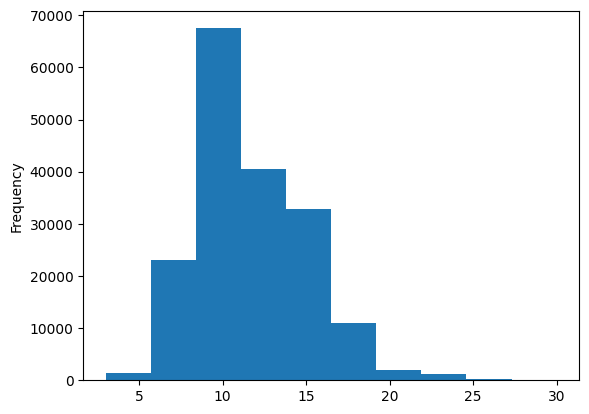

In [ ]:
train_df.total_lines.plot.hist()

Okey it looks like that the most of the obstract are around 7 to 15 sentences in length.

# Get list of sentences

When building our deep learning model, we will require sentences as input, specifically the lines of an abstract.

To easily obtain these sentences from our DataFrame, we can use the `tolist()` method on the `text` column.


In [ ]:
# Creating lists of abstract text lines for the training, validation, and test sets
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

# Display the number of sentences in each set
len(train_sentences), len(val_sentences), len(test_sentences)


(180040, 30212, 30135)

In [ ]:
# Displaying the first 10 lines of training sentences , to Take a look of our training sentences
train_sentences[:10]


['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

# Make numeric labels

We are going to create one-hot and label-encoded labels.


In [ ]:
# Importing the OneHotEncoder from sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False) # Creating an instance of the OneHotEncoder


train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1)) # One-hot encoding the training labels
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1)) # One-hot encoding the validation labels
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1)) # One-hot encoding the test labels

# Displaying the one-hot encoded training labels
train_labels_one_hot


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

# Label encode labels

Extract labels `"target" columns` and encode them into integers

In [ ]:
# Importing the LabelEncoder from sklearn.preprocessing
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder() # Creating an instance of the LabelEncoder

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy()) # Encoding the training labels into integers
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy()) # Encoding the validation labels into integers
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy()) # Encoding the test labels into integers

# Displaying the shape and content of the encoded training labels
train_labels_encoded.shape, train_labels_encoded


((180040,), array([3, 2, 2, ..., 4, 1, 1]))

Now we've trained an instance of `LabelEncoder` , we can get the class names and numbers of classes using the `classes_` attribute.

Get `class names` and `number of classes` from `LabelEncoder instance`

In [ ]:
# Getting the number of classes and class names from the LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

# Displaying the number of classes and class names
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

#Let's check what whe have untel now !!

In [ ]:
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
train_lines[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [ ]:
train_samples[:5]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

# Baseline Model

our baseline model Will be the `TF-IDF Moulinomail Naive Bayes` as Recomended by the `scikt-learn maxhine learning map `

In [ ]:
# Create a pipeline for text classification using TF-IDF and Multinomial Naive Bayes

# Importing necessary modules from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Creating a pipeline with TF-IDF vectorizer and Multinomial Naive Bayes classifier
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fitting the pipeline to the training data
model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

Due to the speed of the Mulinomial Naive Bayes algorithm , it trains very quit
We can evaluate our model's accuracy on the validation dataset using the `score()` method

In [ ]:
model_0_score = model_0.score(X=val_sentences, y=val_labels_encoded)

# Displaying the accuracy of the model on the validation set
model_0_score

0.7218323844829869

Now Let's make some predictions on the test data for more evaluation

In [ ]:
baseline_pred = model_0.predict(X=val_sentences)

# Displaying the predictions made by the baseline model on the validation set
baseline_pred

array([4, 1, 3, ..., 4, 4, 1])

# create a helper function to calculate the :
 * accuracy
 * precision
 * Recall
 * F1-score

In [ ]:
# Define a function to calculate evaluation metrics (accuracy, precision, recall, and F1 score)

# Importing necessary modules from sklearn
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculates and returns evaluation metrics for a model.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.

    Returns:
        dict: A dictionary containing the model's accuracy, precision, recall, and F1 score.
    """

    model_accuracy = accuracy_score(y_true, y_pred) # Calculate the model accuracy

    # Calculate model precision, recall, and F1 score using "weighted average"
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    # Store the results in a dictionary
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}

    return model_results

Calculate `evaluation metrics` for the **baseline model** on the validation set Using the defined function to calculate evaluation metrics

In [ ]:
baseline_results = calculate_results(y_true=val_labels_encoded, y_pred=baseline_pred)

In [ ]:
# Displaying the results of the baseline model on the validation set
baseline_results

{'accuracy': 0.7218323844829869,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# preparing the data for our Deep sequence models

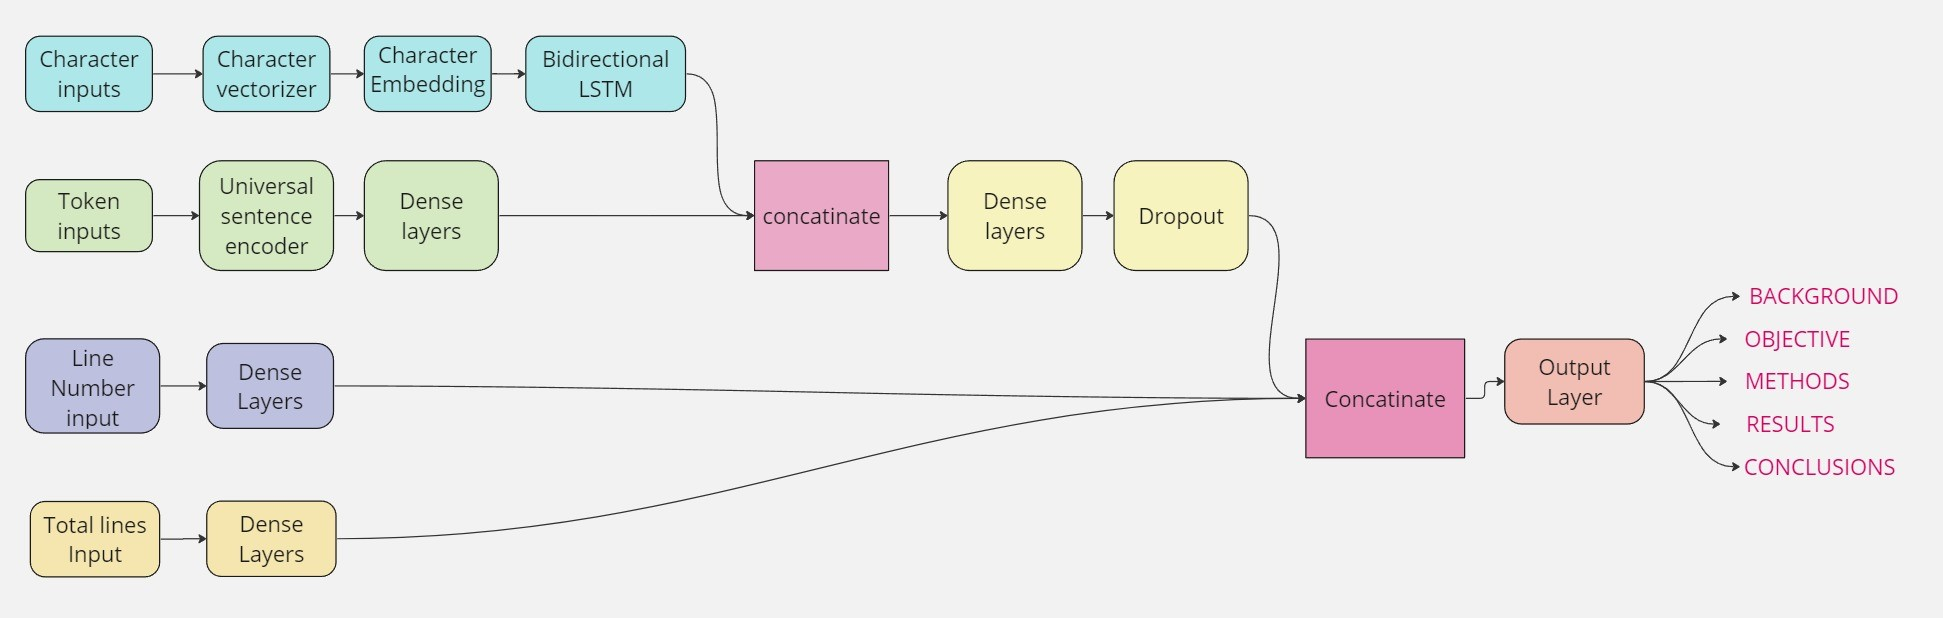

## Create the text vectorizer

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# Calculate the length of each sentence and find the average sentence length
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)

# Displaying the average sentence length in terms of tokens
avg_sent_len

26.338269273494777

Visualize the distribution of sentence lengths

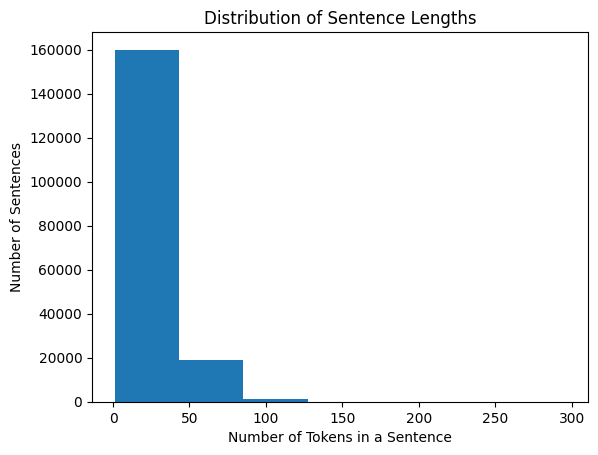

In [ ]:
import matplotlib.pyplot as plt

# Creating a histogram to visualize the distribution of sentence lengths
plt.hist(sent_lens, bins=7)
plt.xlabel('Number of Tokens in a Sentence')
plt.ylabel('Number of Sentences')
plt.title('Distribution of Sentence Lengths')
plt.show()

Looks like the vast majority of sentences are between 0 and 50 tokens in length.

we can use Numpy's `percentile` to finde the value which cover 95% of the sentence lengths.

In [ ]:
# Calculate the sentence length that covers 95% of the lengths
output_seq_len = int(np.percentile(sent_lens, 95))

# Displaying the calculated sentence length
output_seq_len

55

Determine the maximum sentence length in the training set

In [ ]:
max_sent_len = max(sent_lens) # Finding the maximum sentence length in the training set

max_sent_len # Displaying the maximum sentence length

296

In [ ]:
# How many wordsare in our vocabulary ? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)

max_tokens = 68000

And since discovered a sentence length of 55 cover 95% of the training sentences , we'll use that as our `output_sequence_length` parameter

 So let's Create a text vectorizer

In [ ]:
# Importing necessary modules from TensorFlow
from tensorflow.keras.layers import TextVectorization

# Creating a TextVectorization layer with specified parameters
text_vectorizer = TextVectorization(max_tokens=max_tokens,  # the number of words in the vocabulary
                                    output_sequence_length=55  # Desired output length of vectorized sequences
                                    )

In [ ]:
# Addapte text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

Test the text vectorizer

In [ ]:
import random # Importing the random module for selecting a random sentence

target_sentence = random.choice(train_sentences) # Selecting a random sentence from the training set

# Displaying the selected text, its length, and the vectorized representation
print(f"Text:\n {target_sentence}")
print(f"\n Length of text: {len(target_sentence.split())}")
print(f"\n Vectorized text:\n {text_vectorizer([target_sentence])}")


Text:
 patients undergoing surgery were admitted on the day of surgery and were discharged the day after surgery .

 Length of text: 18

 Vectorized text:
 [[  12  295  115    9 1748   18    2  108    4  115    3    9 3994    2
   108   21  115    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


Check the number of words in the training vocabulary

In [ ]:
# Getting the vocabulary from the text vectorizer
rct_20k_text_vocab = text_vectorizer.get_vocabulary()

# Displaying the number of words in the vocabulary, most common, and least common words
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")


Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


we can also acces to the configuration of our `text_vectorizer` we can use the `get_config()` method

In [ ]:
# Displaying the configuration of the text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Pretrained Token embeddings

We'll keep the pretrained embeddings frozen (by setting trainable=False) and add a trainable couple of layers on the top to tailor the model outputs to our own data.

> 🔑 Note: Due to having to download a relatively large model (~916MB), the cell below may take a little while to run.

In [ ]:
import tensorflow_hub as hub # Importing the TensorFlow Hub module

# Creating a KerasLayer for the universal-sentence-encoder
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                       trainable=False,
                                       name="universal_sentence_encoder")

Test the embedding on a random sentence using TensorFlow Hub

In [ ]:
random_training_sentence = random.choice(train_sentences) # Selecting a random sentence from the training set

# Displaying the random training sentence and its embedded representation
print(f"Random training sentence:\n {random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])

print(f"Sentence after embedding:\n {use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n {len(use_embedded_sentence[0])}")


Random training sentence:
 a @-month quasi-experimental trial of a qi program in @ nursing homes ( @ comparison , @ intervention ) conducted from march to november @ .

Sentence after embedding:
 [-0.01016339 -0.00643562 -0.02847277 -0.04395263 -0.01723749 -0.04088763
  0.02080317 -0.04758792 -0.00694054  0.04291234  0.08116334 -0.04459472
 -0.00587334  0.02176297  0.06887092 -0.02390518 -0.09220148  0.06863908
 -0.02654842 -0.00263456 -0.06751157  0.00304282  0.06366245 -0.01965127
  0.04509225  0.04103912  0.00671553  0.04169649  0.00115005  0.03720314] (truncated output)...

Length of sentence embedding:
 512


## Character embeddings

### Creating a charachter-level tokenizer

Create a function to split sentences into characters

In [ ]:
def split_chars(text):
    """Splits a text sequence into individual characters and returns a space-separated string.

    Args:
        text (str): Input text sequence.

    Returns:
        str: A space-separated string of individual characters.
    """
    return " ".join(list(text))

# Test splitting a non-character-level sequence into characters
split_chars(random_training_sentence)

'a   @ - m o n t h   q u a s i - e x p e r i m e n t a l   t r i a l   o f   a   q i   p r o g r a m   i n   @   n u r s i n g   h o m e s   (   @   c o m p a r i s o n   ,   @   i n t e r v e n t i o n   )   c o n d u c t e d   f r o m   m a r c h   t o   n o v e m b e r   @   .'

Let's create a character level datasets by spliting our sequence datasets into characters

In [ ]:
# >> Split sequence-level data splits into character-level data splits


train_char = [split_chars(sentence) for sentence in train_sentences] # Applying the split_chars function to each sentence in the training set
val_char = [split_chars(sentence) for sentence in val_sentences] # Applying the split_chars function to each sentence in the validation set
test_char = [split_chars(sentence) for sentence in test_sentences] # Applying the split_chars function to each sentence in the test set


Display the original and character-level representations of a training sentence

In [ ]:

print(train_sentences[0]) # Displaying the original training sentence
print("\n\n")
print(train_char[0]) # Displaying the character-level representation of the same sentence


to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .



t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


Calculate the average character length

In [ ]:
# Calculate the length of each sentence in terms of characters
char_lens = [len(sentence) for sentence in train_sentences]

# Calculate the average character length
mean_char_len = np.mean(char_lens)

# Displaying the average character length
mean_char_len

149.3662574983337

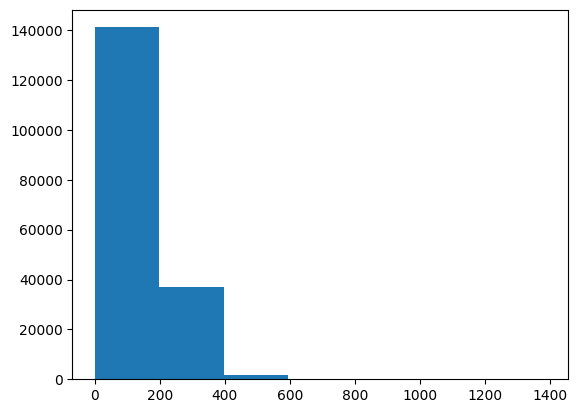

In [ ]:
# Check teh distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens , bins=7);

Determine the character length that covers 95% of sequences

In [ ]:
# Calculate the character length that covers 95% of the sequences
output_seq_char_len = int(np.percentile(char_lens, 95))

# Displaying the calculated character length
output_seq_char_len

290

Wonderful , now we know the sequence length which covers 95% of sequences , we'll use that in our `TextVectorization` layer as the `output_sequence_length` parameter .

We'll set `max_tokens` (the total number of different characters in our sequences) to 28, in other words, 26 letters of the alphabet + space + OOV (out of vocabulary or unknown) tokens.

In [ ]:
# Get all keyboard characters for character-level embedding

import string # Importing the string module
alphabet = string.ascii_lowercase + string.digits + string.punctuation # Creating a string containing all lowercase letters, digits, and punctuation
alphabet  # Displaying the resulting alphabet string


'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Create a character-level token vectorizer instance

In [ ]:
# Calculate the number of characters in the alphabet plus space and OOV token
num_char_tokens = len(alphabet) + 2  # num characters in alphabet + space + OOV token

# Creating a TextVectorization layer for character-level tokenization
char_vectorizer = TextVectorization(max_tokens=num_char_tokens,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt the character vectorizer to the training characters
char_vectorizer.adapt(train_char)

Check character vocabulary characteristics

In [ ]:
# Getting the character vocabulary from the character vectorizer
char_vocab = char_vectorizer.get_vocabulary()

# Displaying characteristics of the character vocabulary
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]} ")
print(f"5 least common characters: {char_vocab[-5:]}")


Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i'] 
5 least common characters: ['k', 'x', 'z', 'q', 'j']


Test out the character vectorizer

In [ ]:
# Selecting a random character representation from the training set
random_train_chars = random.choice(train_char)

# Displaying the charified text, its length, and the vectorized representation
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")


Charified text:
t h e   a g e   ,   g e n d e r   ,   o c c u p a t i o n   ,   g r a d e   o f   p t e r y g i u m   e x t e n t   a n d   d e g r e e   o f   f l e s h i n e s s   ,   a n d   l a t e r a l i t y   w e r e   c o m p a r e d   b e t w e e n   r e c u r r e n t   a n d   n o   r e c u r r e n t   p t e r y g i a   .

Length of chars: 133

Vectorized chars:
[[ 3 13  2  5 18  2 18  2  6 10  2  8  7 11 11 16 14  5  3  4  7  6 18  8
   5 10  2  7 17 14  3  2  8 19 18  4 16 15  2 24  3  2  6  3  5  6 10 10
   2 18  8  2  2  7 17 17 12  2  9 13  4  6  2  9  9  5  6 10 12  5  3  2
   8  5 12  4  3 19 20  2  8  2 11  7 15 14  5  8  2 10 22  2  3 20  2  2
   6  8  2 11 16  8  8  2  6  3  5  6 10  6  7  8  2 11 16  8  8  2  6  3
  14  3  2  8 19 18  4  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  

## Creating a char level-embedding

In [ ]:
# Creating an Embedding layer for character-level embedding
char_embed = layers.Embedding(input_dim=num_char_tokens,  # Number of different characters
                              output_dim=25,  # Embedding dimension of each character (same as figure 1 in the paper)
                              mask_zero=False,
                              name="char_embed")


Test the character embedding layer

In [ ]:
# Displaying the charified text before vectorization and embedding
print(f"Charified text (before vectorization and embedding):\n{random_train_chars} \n")

# Applying the character vectorizer and embedding to the random character representation
char_embed_example = char_embed(char_vectorizer([random_train_chars]))

# Displaying the embedded characters and the shape of the embedding
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")


Charified text (before vectorization and embedding):
t h e   a g e   ,   g e n d e r   ,   o c c u p a t i o n   ,   g r a d e   o f   p t e r y g i u m   e x t e n t   a n d   d e g r e e   o f   f l e s h i n e s s   ,   a n d   l a t e r a l i t y   w e r e   c o m p a r e d   b e t w e e n   r e c u r r e n t   a n d   n o   r e c u r r e n t   p t e r y g i a   . 

Embedded chars (after vectorization and embedding):
[[[-0.0186736   0.02837943 -0.00515349 ...  0.01305575  0.03780291
    0.01422142]
  [ 0.01965125 -0.02968603 -0.00747461 ...  0.01211673  0.03829566
   -0.03583108]
  [-0.02750384 -0.04818083 -0.01627142 ... -0.03796738  0.02625017
   -0.02033659]
  ...
  [-0.03453696 -0.03144981 -0.04894694 ...  0.03916575 -0.02371479
    0.04730577]
  [-0.03453696 -0.03144981 -0.04894694 ...  0.03916575 -0.02371479
    0.04730577]
  [-0.03453696 -0.03144981 -0.04894694 ...  0.03916575 -0.02371479
    0.04730577]]]

Character embedding shape: (1, 290, 25)


## Line Number input & #Totale line input

Inspect the training DataFrame

In [ ]:
train_df.head() # Displaying the first few rows of the training DataFrame

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


 Check the distribution of line numbers in the training DataFramem

In [ ]:
# Displaying the count of each line number in the training DataFrame
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

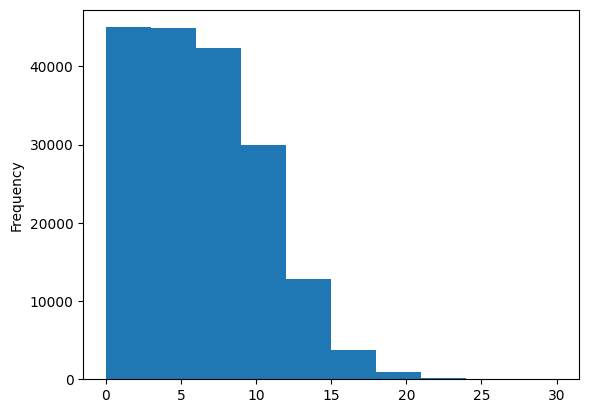

In [ ]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

Use TensorFlow to create one-hot encoded tensors of the "line_number" column

In [ ]:
# Creating one-hot encoded tensors for the "line_number" column in the training set
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)

# Creating one-hot encoded tensors for the "line_number" column in the validation set
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)

# Creating one-hot encoded tensors for the "line_number" column in the test set
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

Check one-hot encoded **line_number** feature samples

In [ ]:
# Displaying the shape and first 20 samples of the one-hot encoded "line_number" feature in the training set
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

We can do the same as we've done for our `line_number` column with the `total_lines`
column ,First let's find an apprppriate value for the `depth` parameter of `tf.one_hot`

Check the distribution of the total number of lines in the training DataFrame

In [ ]:
train_df["total_lines"].value_counts() # Displaying the count of each total number of lines in the training DataFrame

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

Plot a histogram of the total number of lines in the training DataFrame , Using the `plot.hist()` method to visualize the distribution of total lines in the training DataFrame

<Axes: ylabel='Frequency'>

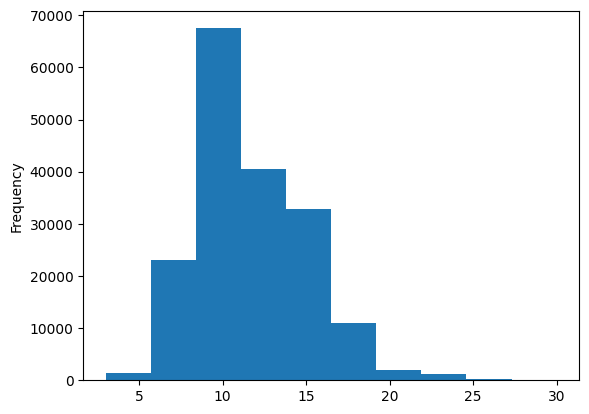

In [ ]:
train_df.total_lines.plot.hist()

Check the average of a **total_lines** value of 20

In [ ]:
# Calculating the value of "total_lines" that covers 98% of samples
percentile_98 = np.percentile(train_df.total_lines, 98)

# Displaying the calculated value
percentile_98

20.0

Use TensorFlow to create one-hot encoded tensors of the `total_lines` column

In [ ]:
# Creating one-hot encoded tensors for the "total_lines" column in the training set
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)

# Creating one-hot encoded tensors for the "total_lines" column in the validation set
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)

# Creating one-hot encoded tensors for the "total_lines" column in the test set
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

Check shape and samples of the one-hot encoded **total_lines** tensor

In [ ]:
# Displaying the shape and samples of the one-hot encoded "total_lines" tensor in the training set
train_total_lines_one_hot.shape, train_total_lines_one_hot[10:20]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

## create the architecter

In [ ]:
# Define the hybrid model architecture

# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together the model
Deep_seq_model = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

Display the summary of the token, char, and positional embedding model

In [ ]:
# Displaying the summary of the Deep Sequence model
Deep_seq_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

Let's Plot our Deep Sequence model

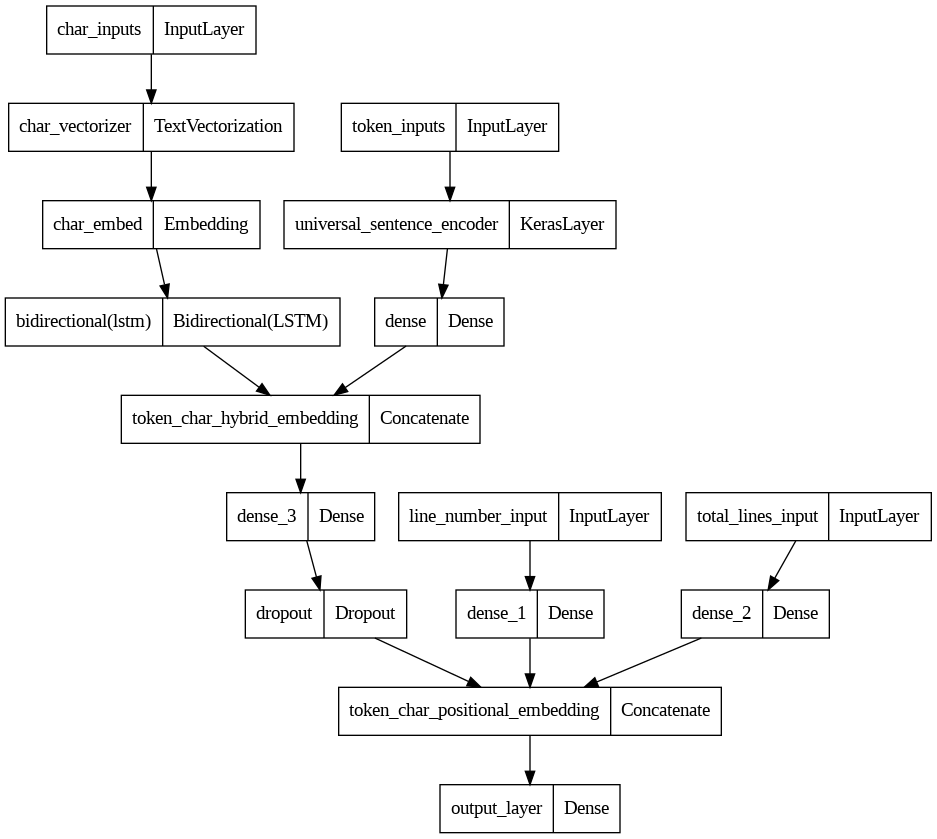

In [ ]:
# Importing necessary modules from TensorFlow
from tensorflow.keras.utils import plot_model

# Plotting the architecture of the Deep Sequence model
plot_model(Deep_seq_model)


Check which layers of the Deep Sequence model are trainable or not

In [ ]:
# Iterating through each layer in the Deep Sequence model and printing its name along with its trainable status
for layer in Deep_seq_model.layers:
    print(layer, layer.trainable)


<keras.src.engine.input_layer.InputLayer object at 0x7d78731920e0> True
<keras.src.engine.input_layer.InputLayer object at 0x7d79901318d0> True
<keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x7d78730d8910> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7d78ff60c700> False
<keras.src.layers.core.embedding.Embedding object at 0x7d78730f5810> True
<keras.src.layers.core.dense.Dense object at 0x7d790119bee0> True
<keras.src.layers.rnn.bidirectional.Bidirectional object at 0x7d7872d1b0a0> True
<keras.src.layers.merging.concatenate.Concatenate object at 0x7d787310eb00> True
<keras.src.engine.input_layer.InputLayer object at 0x7d795c2ed150> True
<keras.src.engine.input_layer.InputLayer object at 0x7d78feeaaaa0> True
<keras.src.layers.core.dense.Dense object at 0x7d7873132dd0> True
<keras.src.layers.core.dense.Dense object at 0x7d787301fa00> True
<keras.src.layers.core.dense.Dense object at 0x7d7872d1ac50> True
<keras.src.layers.regularization.dropout.

In [ ]:
# Compile the Deep Sequence model
Deep_seq_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=["accuracy"])

## Create tribrid embedding dataset and fit the model

In [ ]:
# Training dataset
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,  # Line numbers
                                                                train_total_lines_one_hot,    # Total lines
                                                                train_sentences,              # Token inputs
                                                                train_char                    # Char inputs
                                                                ))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)  # Train labels

train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))  # Combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)  # Turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_char))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)  # Turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset


(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Let's finally fit our model

history_Deep_seq_model = Deep_seq_model.fit(train_pos_char_token_dataset,
                                            steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                                            epochs=3,
                                            validation_data=val_pos_char_token_dataset,
                                            validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 33s 45ms/step - loss: 1.1005 - accuracy: 0.7182 - val_loss: 0.9882 - val_accuracy: 0.7999
Epoch 2/3
562/562 [==============================] - 22s 39ms/step - loss: 0.9699 - accuracy: 0.8147 - val_loss: 0.9534 - val_accuracy: 0.8278
Epoch 3/3
562/562 [==============================] - 22s 38ms/step - loss: 0.9517 - accuracy: 0.8223 - val_loss: 0.9419 - val_accuracy: 0.8278


In [ ]:
# Evaluating the Deep Sequence model on the validation dataset
Deep_seq_model.evaluate(val_pos_char_token_dataset)


945/945 [==============================] - 25s 26ms/step - loss: 0.9397 - accuracy: 0.8298


[0.9397136569023132, 0.8297696113586426]

Make predictions and visualize the results using the previously created function

In [ ]:
# Make predictions with the Deep Sequence model
Deep_seq_model_pred_probs = Deep_seq_model.predict(val_pos_char_token_dataset)
Deep_seq_model_pred = tf.argmax(Deep_seq_model_pred_probs, axis=1)

945/945 [==============================] - 23s 24ms/step


In [ ]:
# Calculate and display the results using the calculate_results function
Deep_seq_model_results = calculate_results(val_labels_encoded, Deep_seq_model_pred)
Deep_seq_model_results

{'accuracy': 0.8297696279623991,
 'precision': 0.8290009232212237,
 'recall': 0.8297696279623991,
 'f1': 0.8286487167567564}

In [ ]:
# what about the baseline results
baseline_results

{'accuracy': 0.7218323844829869,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Compare model results

Far out, we've come a long way. From a baseline model to training a model containing three different kinds of embeddings.

Now it's time to compare each model's performance against each other.

We'll also be able to compare our model's to the PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper.

Since all of our model results are in dictionaries, let's combine them into a pandas DataFrame to visualize them.


In [ ]:
# Combine model results into a DataFrame

# Creating a DataFrame to combine and visualize the results of the baseline and Deep Sequence models
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "Deep_seq_model": Deep_seq_model_results})

# Transposing the DataFrame for better visualization
all_model_results = all_model_results.transpose()
all_model_results


,accuracy,precision,recall,f1
baseline,0.721832,0.718647,0.721832,0.698925
Deep_seq_model,0.829770,0.829001,0.829770,0.828649


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

Plot and compare all of the model results

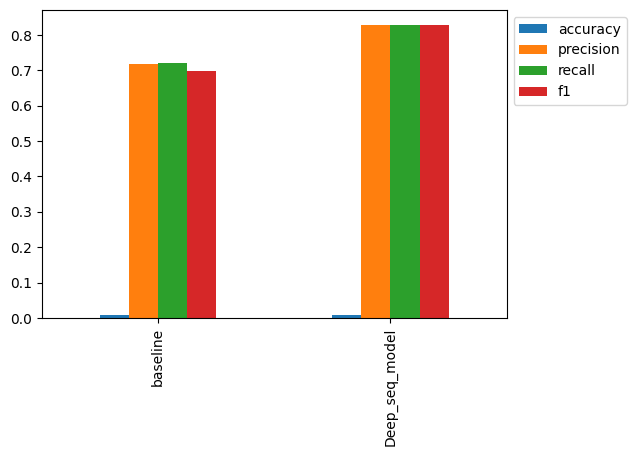

In [ ]:
# Using a bar plot to visualize and compare the results of the baseline and Deep Sequence models
all_model_results.plot(kind="bar", figsize=(6, 4)).legend(bbox_to_anchor=(1.0, 1.0));

Compare F1-scores

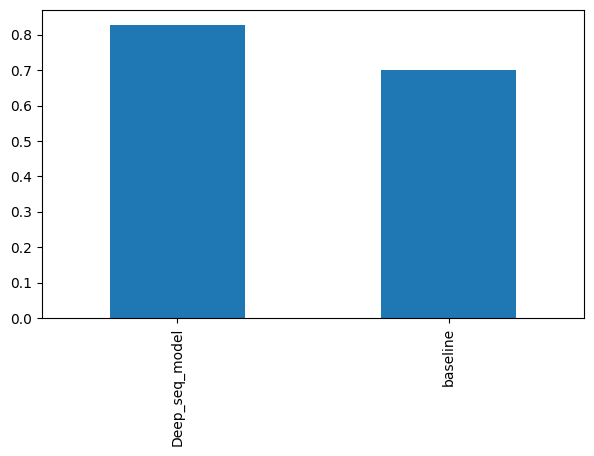

In [ ]:
# Sorting the model results by F1-score and using a bar plot to visualize the results
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(7, 4));


We can save our best performing model by calling the `save()` method on it.


In [ ]:
# Save the best performing model (our Deep_seq_model) to the specified path
Deep_seq_model.save("skimlit_tribrid_model")

In [ ]:
import shutil
from google.colab import files

# Folder to be zipped
folder_path = '/content/skimlit_tribrid_model_down'

# Zip the folder
folder = shutil.make_archive('/content/skimlit_tribrid_model', 'zip', folder_path)

# Download the zip file
files.download(folder)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>